In [71]:
import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, plot_1d_slice, plot_timeseries
from superfv.initial_conditions import sod_shock_tube_1d
from teyssier import riemann

In [72]:
N = 100
T = 0.245

configs = {
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        ZS=True,
        adaptive_dt=True,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        limiting_vars="actives",
        NAD=True,
        absolute_dmp=False,
        NAD_rtol=1e-2,
        NAD_atol=1e-2,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
}

sims = {}
for name, config in configs.items():
    print(f"Running {name}...")
    sim = EulerSolver(ic=sod_shock_tube_1d, bcx="free", nx=N, **config)

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T, allow_overshoot=True)
        else:
            sim.run(T, q_max=2, allow_overshoot=True)
    except Exception as e:
        print(f"Failed: {e}")
        continue

    sims[name] = sim

Running MUSCL-Hancock...
Step #67 @ t=2.46e-01 | dt=3.59e-03 | min(rho)=1.25e-01, min(P)=1.00e-01 | (done)                   
Running ZS3...
Step #67 @ t=2.47e-01 | dt=3.63e-03 | min(rho)=1.25e-01, min(P)=1.00e-01 | (done)                   
Running MM3...
Step #67 @ t=2.47e-01 | dt=3.61e-03 | min(rho)=1.25e-01, min(P)=9.98e-02 | (done)                   


In [73]:
# analytical solution for plotting
xana = (np.arange(1024) + 0.5) / 1024
wana = np.zeros([3, 1024])
for i in range(0, np.size(xana)):
    s = (xana[i] - 0.5) / sim.t
    d, v, p = riemann.exact_solution(s, [1, 0, 1], [0.125, 0, 0.1])
    wana[:, i] = [d, v, p]

(0.0, 1.0)

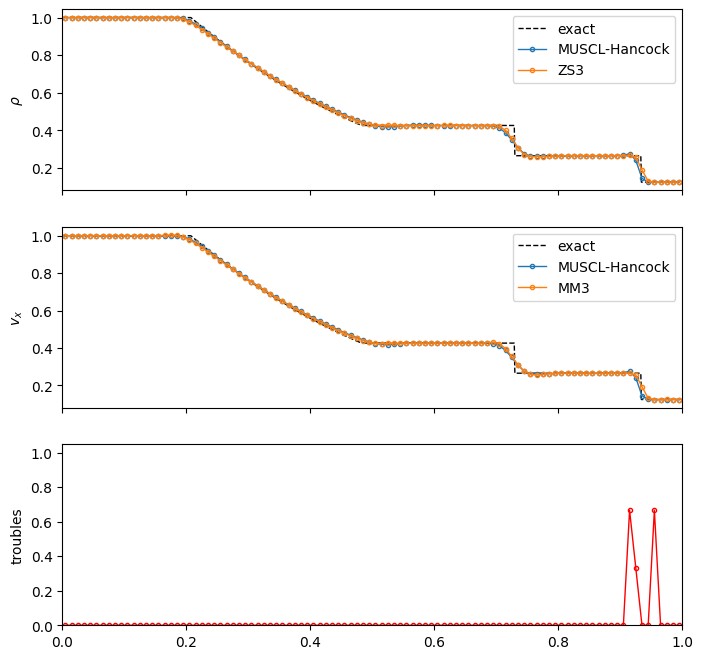

In [74]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey="row", figsize=(8, 8))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")
axs[2].set_ylabel("troubles")
axs[2].set_ylim(0, 1.05)

style = dict(linewidth=1, markersize=3)

axs[0].plot(xana, wana[0], color="k", linestyle="--", label="exact", **style)
axs[1].plot(xana, wana[0], color="k", linestyle="--", label="exact", **style)

for name, sim in sims.items():
    jlist = [0, 1] if name == "MUSCL-Hancock" else [1] if sim.MOOD else [0]
    for j in jlist:
        plot_1d_slice(
            sim,
            axs[j],
            "rho",
            label=name,
            marker="o",
            mfc="none",
            **style,
        )
        if sim.MOOD:
            plot_1d_slice(
                sim, axs[2], "troubles", color="r", marker="o", mfc="none", **style
            )


axs[0].legend()
axs[1].legend()

axs[0].set_xlim(0, 1)

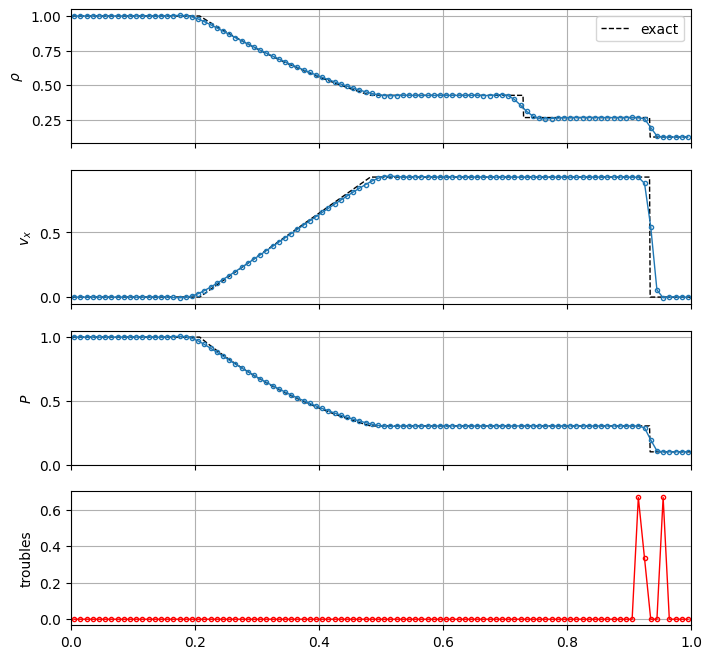

In [75]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey="row", figsize=(8, 8))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")
axs[2].set_ylabel(r"$P$")
axs[3].set_ylabel("troubles")
axs[0].set_xlim(0, 1)
axs[2].set_ylim(0, 1.05)
for i in range(4):
    axs[i].grid()

style = dict(linewidth=1, markersize=3)

axs[0].plot(xana, wana[0], color="k", linestyle="--", label="exact", **style)
axs[1].plot(xana, wana[1], color="k", linestyle="--", label="exact", **style)
axs[2].plot(xana, wana[2], color="k", linestyle="--", label="exact", **style)

sim = sims["MM3"]

plot_1d_slice(sim, axs[0], "rho", marker="o", mfc="none", **style)
plot_1d_slice(sim, axs[1], "vx", marker="o", mfc="none", **style)
plot_1d_slice(sim, axs[2], "P", marker="o", mfc="none", **style)
plot_1d_slice(sim, axs[3], "troubles", color="r", marker="o", mfc="none", **style)


axs[0].legend()

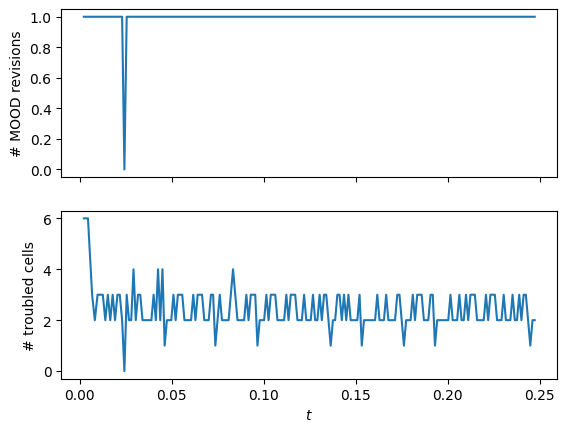

In [76]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].set_ylabel("# MOOD revisions")
axs[1].set_ylabel("# troubled cells")
axs[1].set_xlabel(r"$t$")

sim = sims["MM3"]

plot_timeseries(sim, axs[0], "nfine_MOOD_iters")
plot_timeseries(sim, axs[1], "nfine_troubled_cells")